# <center>[Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge)<br>Capstone 3<br></center>
### <center>By Hector Cadeaux</center><br><br>
## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
import scikitplot as skplt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, f1_score, accuracy_score, recall_score, precision_score

In [3]:
corpus = pd.read_csv('train.csv')
corpus

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
corpus.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

<Axes: >

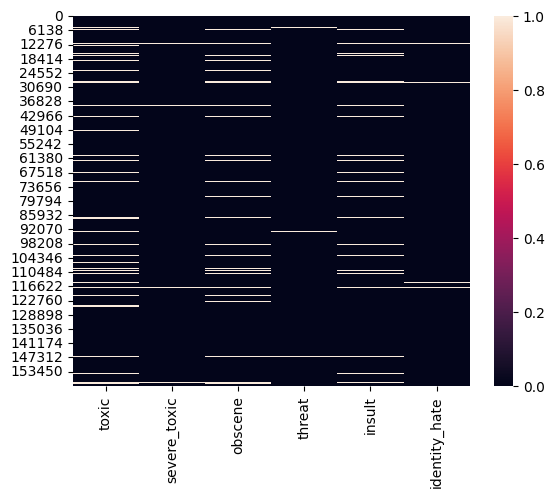

In [5]:
graph_df = corpus[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
sns.heatmap(graph_df)


{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405}


<BarContainer object of 6 artists>

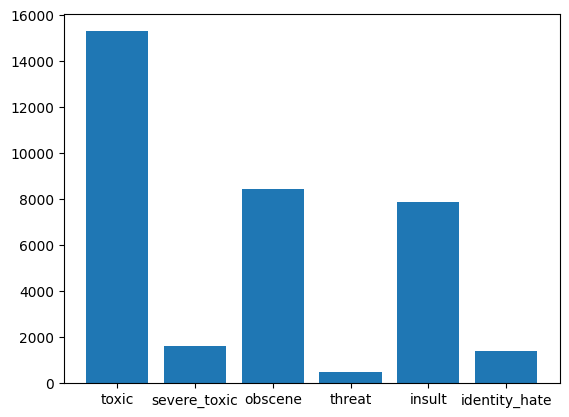

In [6]:
count_dict= dict()
for col in graph_df.columns:
    count_dict[col] = int(graph_df[col].sum())
print(count_dict)
plt.bar(count_dict.keys(),count_dict.values())

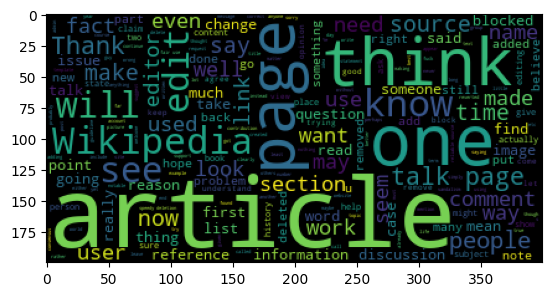

In [7]:
text =" ".join(corpus['comment_text'])
wordcloud = WordCloud()
wordcloud.generate(text)
plt.imshow(wordcloud)
plt.show()

In [8]:
def label_wc(label):
    df= corpus[corpus[label]!=0]
    text = " ".join(df['comment_text'].str.lower())
    wc= WordCloud()
    wc.generate(text)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    

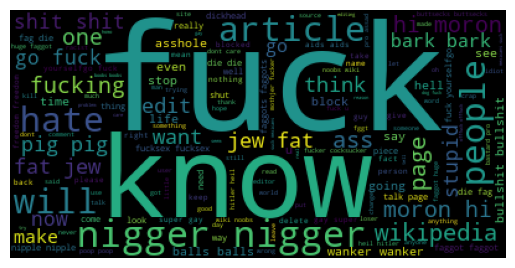

In [9]:
label_wc('toxic')

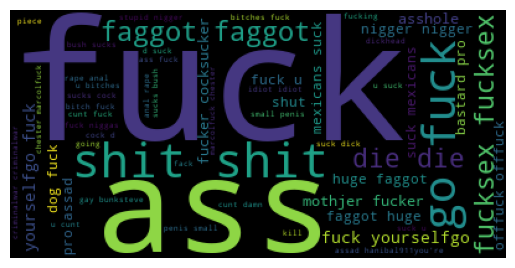

In [10]:
label_wc('severe_toxic')

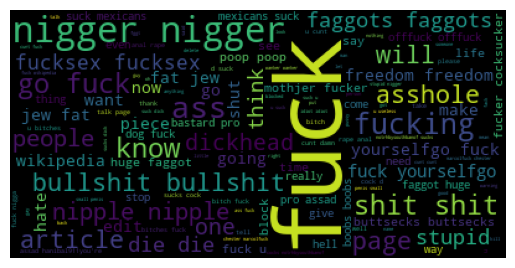

In [11]:
label_wc('obscene')

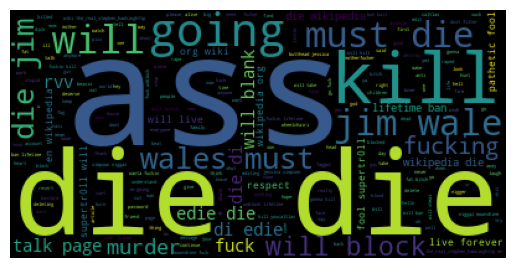

In [12]:
label_wc('threat')

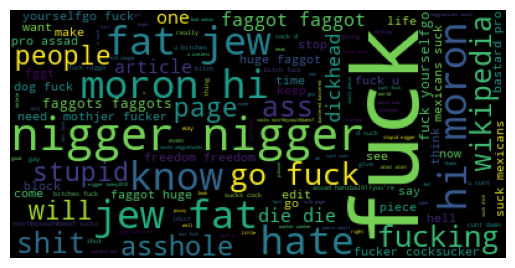

In [13]:
label_wc('insult')

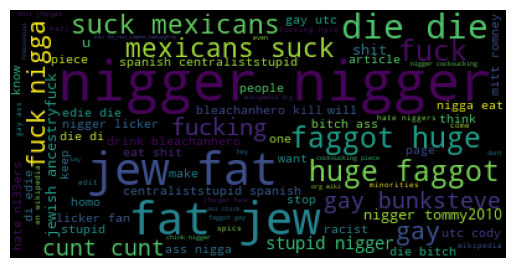

In [14]:
label_wc('identity_hate')

In [15]:
corpus.iloc[3,1]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [16]:
X= corpus[['comment_text']]
y= corpus.drop(columns=['id','comment_text'])

from sklearn.model_selection import train_test_split

trainX, trainy, validX, validy = train_test_split(X, y, test_size=.3, random_state=50)


In [33]:
def tf_model(modle):
    vectorizer = TfidfVectorizer(input='content', analyzer='word',stop_words='english', ngram_range=(2,4))
    vec_train = vectorizer.fit_transform(trainX.data)
    vec_valid = vectorizer.transform(validX.data)
    modle.fit(vec_train,trainy)
    mod_TT_pred = modle.predict(vec_train)
    cm_modle_tr= confusion_matrix(trainy,mod_TT_pred)
    print("f1-score: ", f1_score(trainy,mod_TT_pred))  
    modle_v_pred = modle.predict(vec_valid)
    cm_modle_v= confusion_matrix(validy,modle_v_pred)
    print("Valid f1-score: ", f1_score(validy,modle_v_pred))

    y_probas = modle.predict_proba(vec_valid) 
    (ax1) =plt.subplots(1)
    
    preds = y_probas[:,1]
    fpr, tpr, threshold = roc_curve(validy, preds)
    roc_auc = auc(fpr, tpr)

    ax1=plt.title('Receiver Operating Characteristic')
    ax1=plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    ax1=plt.legend(loc = 'lower right')
    ax1=plt.plot([0, 1], [0, 1],'r--')
    ax0= skplt.metrics.plot_lift_curve(validy, y_probas)

    y_pred_proba = modle.predict_proba(trainX)

    cuts = [.01*k for k in range(0,100)]
    accuracy, f1, precision, recall = ([],[],[],[])
    for thresholds in cuts:
        y_pred = [1 if y[1] >= thresholds else 0 for y in y_pred_proba]
        accuracy_scores = accuracy_score(y_pred, trainy)
        accuracy.append(accuracy_scores)
        f1_scores = f1_score(y_pred, trainy)
        f1.append(f1_scores)
        precision_scores = precision_score(y_pred, trainy)
        precision.append(precision_scores)
        recall_scores = recall_score(y_pred, trainy)
        recall.append(recall_scores)
    cut_df = pd.DataFrame({
    "accuracy":accuracy
    ,"f1":f1
    ,"precision":precision
    ,"recall":recall
    },index =cuts)
    cmt = ""
    for col in cut_df.columns:
        cmt += "Max {} of {} at {}\n".format(col,cut_df[col].max(),cut_df[col].idxmax())
    cut_df.plot.line(title = cmt)
    plt.show()

In [25]:
def count_model(modle):
    vectorizer = CountVectorizer(input='content', analyzer='word',stop_words='english', ngram_range=(2,4))
    vec_train = vectorizer.fit_transform(trainX.values())
    vec_valid = vectorizer.transform(validX.values())
    modle.fit(vec_train,trainy)
    mod_TT_pred = modle.predict(vec_train)
    cm_modle_tr= confusion_matrix(trainy,mod_TT_pred)
    print("f1-score: ", f1_score(trainy,mod_TT_pred))  
    modle_v_pred = modle.predict(vec_valid)
    cm_modle_v= confusion_matrix(validy,modle_v_pred)
    print("Valid f1-score: ", f1_score(validy,modle_v_pred))

    y_probas = modle.predict_proba(vec_valid) 
    (ax1) =plt.subplots(1)
    
    preds = y_probas[:,1]
    fpr, tpr, threshold = roc_curve(validy, preds)
    roc_auc = auc(fpr, tpr)

    ax1=plt.title('Receiver Operating Characteristic')
    ax1=plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    ax1=plt.legend(loc = 'lower right')
    ax1=plt.plot([0, 1], [0, 1],'r--')
    ax0= skplt.metrics.plot_lift_curve(validy, y_probas)

    y_pred_proba = modle.predict_proba(trainX)

    cuts = [.01*k for k in range(0,100)]
    accuracy, f1, precision, recall = ([],[],[],[])
    for thresholds in cuts:
        y_pred = [1 if y[1] >= thresholds else 0 for y in y_pred_proba]
        accuracy_scores = accuracy_score(y_pred, trainy)
        accuracy.append(accuracy_scores)
        f1_scores = f1_score(y_pred, trainy)
        f1.append(f1_scores)
        precision_scores = precision_score(y_pred, trainy)
        precision.append(precision_scores)
        recall_scores = recall_score(y_pred, trainy)
        recall.append(recall_scores)
    cut_df = pd.DataFrame({
    "accuracy":accuracy
    ,"f1":f1
    ,"precision":precision
    ,"recall":recall
    },index =cuts)
    cmt = ""
    for col in cut_df.columns:
        cmt += "Max {} of {} at {}\n".format(col,cut_df[col].max(),cut_df[col].idxmax())
    cut_df.plot.line(title = cmt)
    plt.show()

In [34]:
tf_model(MultinomialNB())

AttributeError: 'DataFrame' object has no attribute 'data'

In [ ]:
run_model('y', MLPClassifier())

### Preprocessing

#### SMOTE